In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import Hotelling, KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from numpy.linalg import norm

from src import estimate_embeddings, compute_pr_at_k
%matplotlib inline

sns.set_context("talk")

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def rotate(x, angle):
    rads = (angle * np.pi) / 180
    rotated = np.array([
        np.cos(rads) * x[0] - np.sin(rads) * x[1],
        np.sin(rads) * x[0] + np.cos(rads) * x[1],
    ])
    
    return rotated

def find_angle(x, y, target):
    angle = np.arccos(target / (np.linalg.norm(x) * np.linalg.norm(y))) / np.pi * 180
    return angle

def generate_graphs_1(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = X2 * np.sqrt(1+effect_size)

    X = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X2]), block_size[1], axis=0)
        ]
        
    )
    Y = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X3]), block_size[1], axis=0)
        ]
    )

    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_4(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    off_diag = X1 @ X2
    X3 = X2 * np.sqrt(1+effect_size)
    X3 = rotate(X3, find_angle(X1, X3, off_diag)-initial_angle)

    X = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X2]), block_size[1], axis=0)
        ]
        
    )
    Y = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X3]), block_size[1], axis=0)
        ]
    )
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

In [3]:
def compute_pr_at_k(pvals, k, true_labels):
    """
    1 is considered the significant nodes
    """
    idx = np.argsort(pvals)
    sorted_labels = true_labels[idx]
    
    precision = sorted_labels[:k].mean()
    recall = sorted_labels[:k].sum() / sorted_labels.sum()
    
    return precision

def experiment(m, block_1, block_2, p, effect_size, generate_func, reps=100):
    m_per_pop = m // 2
    block_size = np.array([block_1, block_2])
    
    n = block_1 + block_2
    labels = np.array([0] * block_1 + [1] * block_2)

    def worker():
        pvals = np.zeros((3, n))
        X, Y = generate_func(p, effect_size, block_size, m_per_pop)

        for node in range(n):
            try:
                X_node = np.delete(X[:, node, :], node, axis=1)
                Y_node = np.delete(Y[:, node, :], node, axis=1)
                test = Hotelling().test(X_node, Y_node)
                #test = KSample('Dcorr').test(X_node, Y_node, reps=500)
                if np.isnan(test[1]):
                    pvals[0, node] = 0
                else:
                    pvals[0, node] = test[1]
            except:
                pvals[0, node] = 1

        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                try:
                    test = Hotelling().test(Xhat[:, node, :], Yhat[:, node, :])
                    pvals[j, node] = test[1]
                except:
                    pvals[j, node] = 1

        pr = np.array([compute_pr_at_k(pvals[i], block_2, labels) for i in range(3)])

        return pvals, pr
    
    res = Parallel(-1)(delayed(worker)() for _ in range(reps))
    prs = np.array([res[i][1] for i in range(reps)]).mean(axis=0)
    pvals = np.array([res[i][0] for i in range(reps)])
    pvals = np.array(pvals)
    pvals = (pvals < 0.05).mean(axis=0)
    avg_pval_1 = pvals[:, :block_1].mean(axis=1)
    avg_pval_2 = pvals[:, block_1:].mean(axis=1)

    to_append = [m, block_1, block_2, effect_size, generate_func.__name__, *avg_pval_1, *avg_pval_2, * prs]
    return to_append

In [4]:
m = 50
block_1s = np.arange(9, 76, 3) #51
block_2s = np.arange(1, 26) # 51
effect_sizes = [0, 0.3, 1]
generate_funcs = [generate_graphs_1, generate_graphs_4]
p = 0.25

args = [
    dict(p=p, 
         m=m, 
         block_1=block_1, 
         block_2=block_2, 
         effect_size=effect_size, 
         generate_func=generate_func) 
    for block_1, block_2, effect_size, generate_func
    in product(block_1s, block_2s, effect_sizes, generate_funcs)
]

In [5]:
res = []
for arg in tqdm(args):
    res.append(experiment(**arg))

In [6]:
columns = ["m", "block_1", "block_2", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff",
           "row_wise_precision", "omni_precision", "mase_precision"
          ]

df = pd.DataFrame(res, columns=columns)
df.to_csv("./results/20200607_validity.csv", index=False)

In [7]:
df

,m,block_1,block_2,effect_size,model,row_wise_same,omni_same,mase_same,row_wise_diff,omni_diff,mase_diff,row_wise_precision,omni_precision,mase_precision
0,50,9,1,0.0,generate_graphs_1,0.040000,0.040000,0.045556,0.0100,0.0100,0.0500,0.0500,0.1200,0.0900
1,50,9,1,0.0,generate_graphs_4,0.030000,0.056667,0.043333,0.0100,0.0200,0.0500,0.0700,0.0900,0.0400
2,50,9,1,0.3,generate_graphs_1,0.032222,0.038889,0.053333,0.0400,0.0300,0.0300,0.1400,0.1000,0.1100
3,50,9,1,0.3,generate_graphs_4,0.025556,0.048889,0.066667,0.0100,0.0500,0.0300,0.1100,0.1400,0.0700
4,50,9,1,1.0,generate_graphs_1,0.047778,0.071111,0.068889,0.0900,0.1800,0.1300,0.1300,0.2200,0.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,50,75,25,0.0,generate_graphs_4,0.324400,0.051600,0.041467,0.0476,0.0484,0.0404,0.0512,0.2588,0.2520
3446,50,75,25,0.3,generate_graphs_1,0.404667,0.074667,0.449600,0.0748,0.4616,0.5676,0.0528,0.5880,0.3192
3447,50,75,25,0.3,generate_graphs_4,0.325200,0.046133,0.129600,0.0392,0.3352,0.1548,0.0428,0.5572,0.2864
3448,50,75,25,1.0,generate_graphs_1,0.548667,0.295200,0.884933,0.2168,1.0000,1.0000,0.1048,0.9700,0.4932


In [44]:
tmp = df[df.model == "generate_graphs_1"][df.effect_size==0]

<ipython-input-44-5f1708254154>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df.model == "generate_graphs_1"][df.effect_size==0]


In [45]:
row = tmp.omni_same.values.reshape(23, -1)

In [50]:
tmp_df.columns[5:-3]

Index(['row_wise_same', 'omni_same', 'mase_same', 'row_wise_diff', 'omni_diff',
       'mase_diff'],
      dtype='object')

In [53]:
tmp

5       0.030000
11      0.035000
17      0.063333
23      0.095000
29      0.248000
          ...   
3425    1.000000
3431    1.000000
3437    1.000000
3443    1.000000
3449    1.000000
Name: mase_diff, Length: 575, dtype: float64

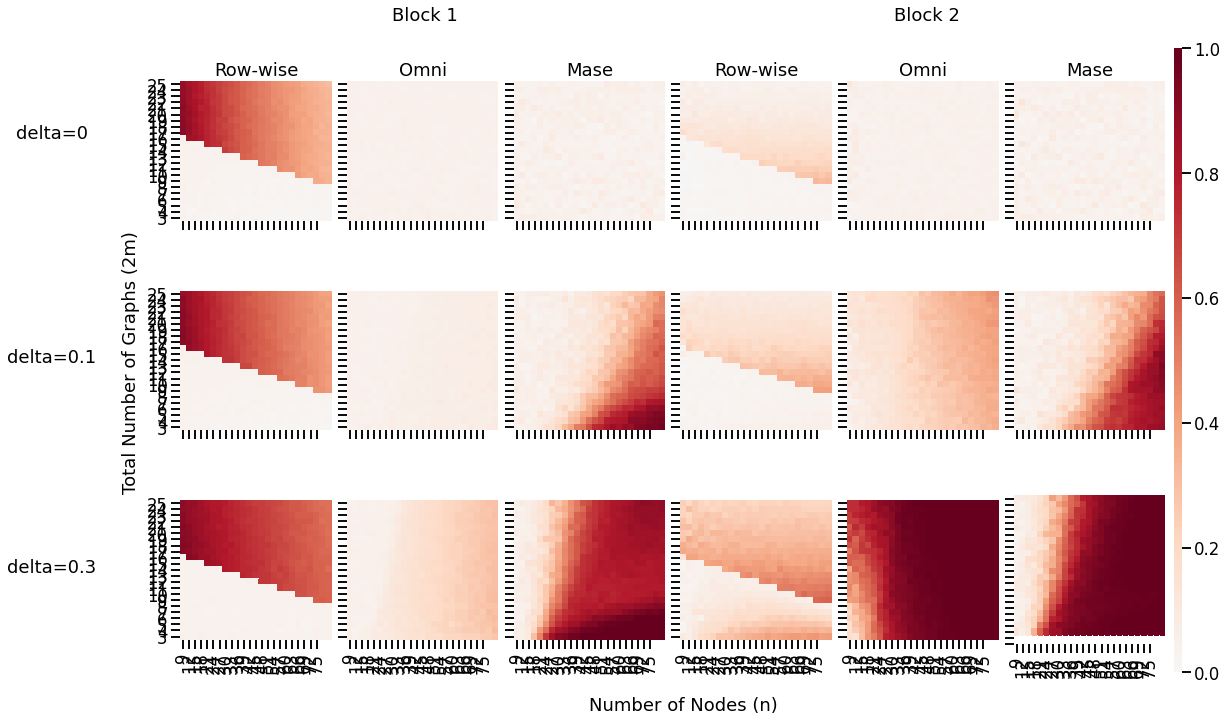

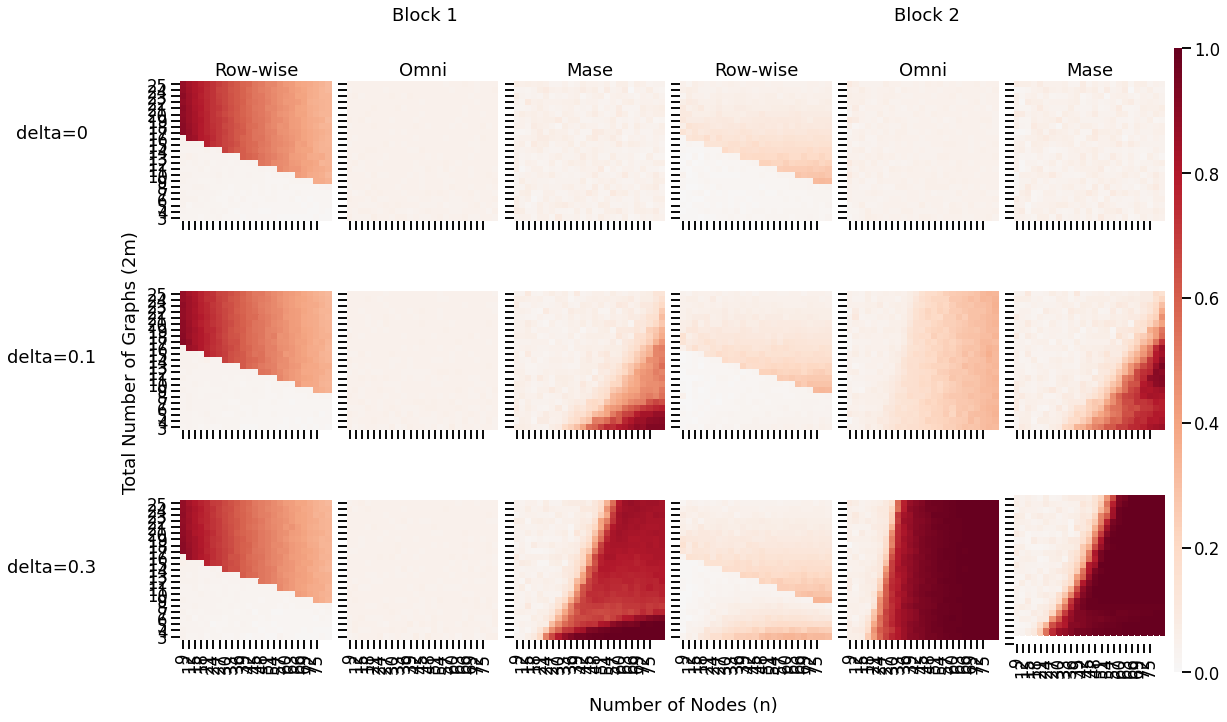

In [51]:
sns.set_context('talk')


for idx, model in enumerate(np.unique(df.model)):
    fig, ax = plt.subplots(
        3, 
        7, 
        figsize=(15, 9),
        sharex=True,
        sharey=True,
        constrained_layout=True,
        gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 1, 0.05]},
    )

    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    col_names = ["Row-wise", 'Omni', 'Mase']
    
    tmp_df = df[df.model == model]

    for row, effect_size in enumerate(pd.unique(tmp_df.effect_size)):
        for col, method in enumerate(tmp_df.columns[5:-3]):
            tmp = tmp_df[tmp_df.effect_size == effect_size][method]
            sns.heatmap(
                np.flipud(tmp.values.reshape(23, -1)),
                square=True,
                cmap='RdBu_r',
                center=0,
                cbar_ax=ax_leg,
                ax = ax[row, col],
                xticklabels=block_1s,
                yticklabels=block_2s[::-1],
                vmin=0,
                vmax=1
            )

            if row == 0:
                ax[row, col].set_title(col_names[col % 3])

    fig.text(0.26, 1.035, "Block 1", va="center", ha="center")
    fig.text(0.725, 1.035, "Block 2", va="center", ha="center")


    row_3 = "delta=0.3"
    row_2 = "delta=0.1"
    row_1 = "delta=0"

    fig.text(-0.085, 0.175, row_3, ha="center")
    fig.text(-0.085, 0.5, row_2, ha="center")
    fig.text(-0.085, 0.845, row_1, ha="center")

    fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
    fig.text(-0.02, 0.5, "Total Number of Graphs (2m)", va="center", rotation="vertical")
#     fig.savefig(f"./figures/20200509_rdpg_angle_{model}.png", dpi=300, bbox_inches='tight')